In [4]:
import numpy as np
import scipy.integrate, scipy.optimize
import matplotlib.pyplot as plt
import pandas
%matplotlib inline

#Load Onose data
H0, H5, H9 = pandas.read_csv('H _ 0T.csv'), pandas.read_csv('H _ 5T.csv'), pandas.read_csv('H _ 9T.csv')
T0, T5, T9 = [H0['Temp^1.5'][j] for j in range(len(H0))], [H5['Temp^1.5'][j] for j in range(len(H5))], [H9['Temp^1.5'][j] for j in range(len(H9))]
C0, C5, C9 = [H0['C'][j] for j in range(len(H0))], [H5['C'][j] for j in range(len(H5))], [H9['C'][j] for j in range(len(H9))]

#Define primitive lattice vectors (FCC in this case)
a = 1
a1 = np.array([1,1,0])*a/2
a2 = np.array([0,1,-1])*a/2
a3 = np.array([1,0,-1])*a/2

#Unit cell volume
V = np.dot(a1,np.cross(a2,a3))

#Reciprocal lattice vectors
b1 = 2*np.pi*np.cross(a2,a3)/V
b2 = 2*np.pi*np.cross(a3,a1)/V
b3 = 2*np.pi*np.cross(a1,a2)/V

#Brillouin zone volume
Vbz = np.dot(b1,np.cross(b2,b3))

#Transformation matrix
B = np.zeros((len(a1),len(a1)))
B[:,0], B[:,1], B[:,2] = b1, b2, b3

Assuming the full dispersion of magnons in the lowest branch $$\epsilon_k = 2J + \mu_B gH - J\sqrt{1 +F(\mathbf{k})},$$ with $F(\mathbf{k}) = \cos \left( \frac{k_x a}{2}\right)\cos \left( \frac{k_y a}{2}\right)+\cos \left( \frac{k_x a}{2}\right)\cos \left( \frac{k_z a}{2}\right)+\cos \left( \frac{k_y a}{2}\right)\cos \left( \frac{k_z a}{2}\right),$ the specific heat is given by

$$C_{\text{mag}}(T,H) = k_B \frac{V}{(2 \pi)^3} \int_{\text{BZ}} \text{d}^3 k \; \frac{x^2(k) e^{x(k)}}{(e^{x(k)}-1)^2}=k_B \int_{(0,1)^3} \text{d}^3 q \; \frac{x^2(B \mathbf{q}) e^{x(B \mathbf{q})}}{(e^{x(B \mathbf{q})}-1)^2}$$

where $x(k) = \epsilon_k/k_B T$ and $$B \equiv \begin{pmatrix} \mathbf{b}_1 & \mathbf{b}_2 & \mathbf{b}_3 \end{pmatrix}$$ is a transformation matrix with columns formed by the reciprocal lattice vectors. The phonon contribution to the heat capacity is $$C_{ph} = \beta T^3.$$

In [3]:
muB = 5.7883818012e-5 #In units eV/T
kB = 8.617333262145e-5 #In units eV/K
NA = 6.02214076e23 #Avogadros number = 1 mol
eVtoJoule = 1.602176634e-19 #1eV in Joules
g = 2 #g-factor
J = 8.2/1000 #Ferromagnetic exchange in eV

def E_mag(k_vec,H):
    '''
    Return energy of lowest magnon branch in units of eV
    '''
    kx, ky, kz = k_vec
    Fk = np.cos(kx*a/2)*np.cos(ky*a/2)+np.cos(kx*a/2)*np.cos(kz*a/2)+np.cos(ky*a/2)*np.cos(kz*a/2)
    
    return muB*g*H+2*J-J*np.sqrt(1+Fk)

def x_func(E,T):
    
    return E/(kB*T)

def integrand(q_vec,T,H):
    '''Integrand for heat capacity integral'''
    k_vec = B@np.array(q_vec)
    xk = x_func(E_mag(k_vec,H),T)
    
    return xk**2*np.exp(xk)/(np.exp(xk)-1)**2

def Cmag(T,H):
    '''Calculate heat capacity in units of kB'''
    
    #Redefine integrand in terms of rescaled momentum q
    g = lambda qz, qy, qx: integrand([qx,qy,qz],T,H)
    print('Running')
    #Integrate over the unit cube
    res = scipy.integrate.tplquad(g, 0, 1, lambda x: 0, lambda x: 1,lambda x, y: 0, lambda x, y: 1)
    
    return res[0],res[1]

x = Cmag(1,0)
print(x)

Running
(0.0019695777549693493, 1.4874977322168798e-08)


In [ ]:
def Cmag(x,H,A):
    '''Magnon heat capacity in units of J / (mol K)'''
    
    Unit = NA*eVtoJoule #Factor to convert eV/K -> J / (mol K)
    
    return A*kB**2.5/(4*np.pi**2)*x*Fvec(g*muB*H*x**(-2/3)/kB)*Unit

def Cph(x,Beta):
    
    return Beta*x**2

def C(Y,A,Beta):
    
    x, H = Y
    
    return 2*(Cmag(x,H,A) + Cph(x,Beta))

H = 5
xl = np.linspace(1,25,100)
Fl = [F(g*muB*H*x**(-2/3)/kB) for x in xl]
plt.plot(xl,Fl)

plt.xlabel('$T^{3/2}(K^{1.5})$',fontsize = 14)
plt.ylabel('$F(g \mu_B H/k_B T ) $',fontsize = 15)
plt.title('Heat capacity energy integral, H = 5T')
plt.show()

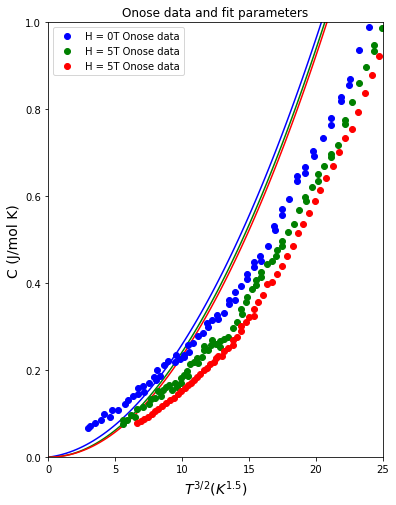

In [37]:
#Onose fitted parameters
Ds = 34 #meV*A^2
Ds = Ds/(1000*(2.49)**2) #convert to eV
A = Ds**(-3/2)
Beta = 1.11e-3 #J/(mol K4)


npts = 100
xlist = np.linspace(0.1,25,npts)
xlist = np.concatenate([xlist,xlist,xlist])

Hlist = []
for H in [0.00001,5,9]:
    
    Hlist = np.concatenate([Hlist,np.repeat(H,npts)])


#Compute heat capacity curves
Ctot = np.array(C([xlist,Hlist],A,Beta))

plt.figure(figsize=(6,8))
plt.plot(xlist[:npts],Ctot[:npts],color = 'blue')
plt.plot(xlist[npts:2*npts],Ctot[npts:2*npts],color = 'green')
plt.plot(xlist[2*npts:],Ctot[2*npts:],color = 'red')


plt.plot(T0,C0,'o', label = 'H = 0T Onose data',color = 'blue')
plt.plot(T5,C5,'o', label = 'H = 5T Onose data',color = 'green')
plt.plot(T9,C9,'o', label = 'H = 5T Onose data',color = 'red')


plt.legend()
plt.xlabel('$T^{3/2}(K^{1.5})$',fontsize=14)
plt.ylabel('C (J/mol K)',fontsize=14)
plt.title('Onose data and fit parameters')
plt.xlim(0,25)
plt.ylim(0,1)

plt.show()


In [38]:
#Refit Onose data to find spin stiffness 
xlist =T0+T5+T9
Hlist = []
Hlist = np.concatenate([Hlist,np.repeat(0.00001,len(C0))])
Hlist = np.concatenate([Hlist,np.repeat(5,len(C5))])
Hlist = np.concatenate([Hlist,np.repeat(9,len(C9))])


res = scipy.optimize.curve_fit(C,[xlist,Hlist],C0+C5+C9)
A, Beta = res[0]

print('Spin stiffness is Ds = {} meV A^2'.format(A**(-2/3)*1000*(2.49)**2))
print('Phonon prefactor is Beta = {} J/mol K^4'.format(Beta))
print('Exchange coupling is J = {} meV'.format(A**(-2/3)*1000))

Spin stiffness is Ds = 16.405514496320052 meV A^2
Phonon prefactor is Beta = 0.0006091821309273519 J/mol K^4
Exchange coupling is J = 2.6460080476637553 meV


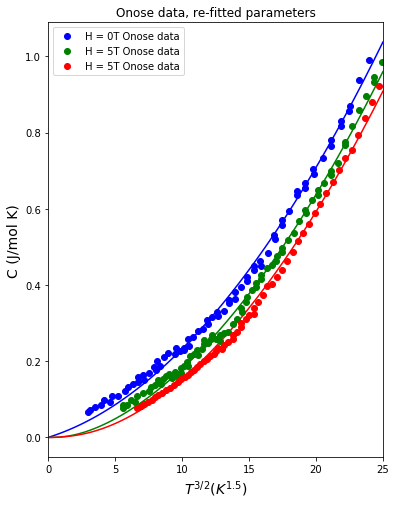

In [43]:
npts = 100
xlist = np.linspace(0.1,25,npts)
xlist = np.concatenate([xlist,xlist,xlist])

Hlist = []
for H in [0.00001,5,9]:
    
    Hlist = np.concatenate([Hlist,np.repeat(H,npts)])


#Compute heat capacity curves
Ctot = C([xlist,Hlist],A,Beta)

plt.figure(figsize=(6,8))
plt.plot(xlist[:npts],np.array(Ctot[:npts]),color = 'blue')
plt.plot(xlist[npts:2*npts],Ctot[npts:2*npts],color = 'green')
plt.plot(xlist[2*npts:],Ctot[2*npts:],color = 'red')


plt.plot(T0,np.array(C0),'o', label = 'H = 0T Onose data',color = 'blue')
plt.plot(T5,np.array(C5),'o', label = 'H = 5T Onose data',color = 'green')
plt.plot(T9,np.array(C9),'o', label = 'H = 5T Onose data',color = 'red')


plt.legend()
plt.xlabel('$T^{3/2}(K^{1.5})$',fontsize=14)
plt.ylabel('C (J/mol K)',fontsize=14)
plt.title('Onose data, re-fitted parameters')
plt.xlim(0,25)
#plt.ylim(0,1)

plt.show()

In [ ]:
#Mena et. al. neutron scattering parameters
J = 8.22 #meV
S = 1/2
Ds = 2.49**2*J
A1 = (Ds/(1000*(2.49)**2))**(-3/2)

xlist =T0+T5+T9
Hlist = []
Hlist = np.concatenate([Hlist,np.repeat(0.00001,len(C0))])
Hlist = np.concatenate([Hlist,np.repeat(5,len(C5))])
Hlist = np.concatenate([Hlist,np.repeat(9,len(C9))])

def Ca(Y,Beta):
    
    return C(Y,A1,Beta)

res = scipy.optimize.curve_fit(Ca,[xlist,Hlist],np.array(C0+C5+C9)/2)
Beta = res[0][0]


print('Spin stiffness (calculated) given by Ds = {} meV A^2'.format(Ds))
print('Phonon prefactor (fitted) is Beta = {} J/mol K^4'.format(Beta))

In [ ]:
npts = 100
xlist = np.linspace(0.1,25,npts)
xlist = np.concatenate([xlist,xlist,xlist])

Hlist = []
for H in [0.00001,5,9]:
    
    Hlist = np.concatenate([Hlist,np.repeat(H,npts)])


#Compute heat capacity curves
Ctot = np.array(C([xlist,Hlist],A,Beta))

plt.figure(figsize=(6,8))
plt.plot(xlist[:npts],Ctot[:npts],color = 'blue')
plt.plot(xlist[npts:2*npts],Ctot[npts:2*npts],color = 'green')
plt.plot(xlist[2*npts:],Ctot[2*npts:],color = 'red')


plt.plot(T0,C0,'o', label = 'H = 0T Onose data',color = 'blue')
plt.plot(T5,C5,'o', label = 'H = 5T Onose data',color = 'green')
plt.plot(T9,C9,'o', label = 'H = 5T Onose data',color = 'red')


plt.legend()
plt.xlabel('$T^{3/2}(K^{1.5})$',fontsize=14)
plt.ylabel('C (J/mol K)',fontsize=14)
plt.title('Onose data, re-fitted parameters with J = 8.22 meV')
plt.xlim(0,25)
plt.ylim(0,1)

plt.show()
